# Capstone: Gift of Life 

## Team Members: Joseph Butcher, Theodore Fong, Ava Rezvani

Months were spent analyzing the 41 other datasets from the Scientific Registry of Transplant Recipients (SRTR) and understanding the various interpretations of each variable and their actual meaning. We decided to narrowly tailor our research interest into kidney organ discards specifically from both requests from our stakeholders and exploring other research questions. The work below reflects the culminative summary of how we analyzed and approached kidney disposition.

#### Outline:
1. Exploratory Data Analysis
2. Feature Engineering for all Models
3. Model Building
4. Kidney Disposition
5. Conclusion
6. Appendix

The dataset diagram below indicates how the 45 datasets were connected to each other and we decided to focus primarily on 'DONOR_DISPOSITION', 'DONOR_DECEASED', and 'INSTITUTION'. These three datasets contain a conglomeration of all the organ donors, what happened to the organ, and the relevant OPO. 

Transplant information and Transplant Follow-up Information were originally explored, but decided not relevant for our main research question. We started to initially look at the variables predicting if an organ transplant recipient would survive for one year, but due to stakeholder analysis, we shifted to the amount of organs being discarded instead.

![title](Project/SAFsLinkingDiagram.png)

## 1. Exploratory Data Analysis

In [2]:
# This code block shows the libraries that we import in for analyzing the data in Python.

# General libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats

# Import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
#from sklearn.metrics import mean_squared_error

In [3]:
# Read in the General data
donor_deceased = pd.read_sas('Project/pubsaf1912/donor_deceased.sas7bdat')
donor_disposition = pd.read_sas('Project/pubsaf1912/donor_disposition.sas7bdat')
institution = pd.read_sas('Project/pubsaf1912/institution.sas7bdat')

In [4]:
print("Donor Deceased dataframe shape is {}".format(donor_deceased.shape))
print("Donor Disposition dataframe shape is {}".format(donor_disposition.shape))
print("Institution dataframe shape is {}".format(institution.shape))

Donor Deceased dataframe shape is (224529, 256)
Donor Disposition dataframe shape is (1673112, 18)
Institution dataframe shape is (705, 15)


We note that the datasets are much larger than expected. We also want to explore the missing data in the dataframes.

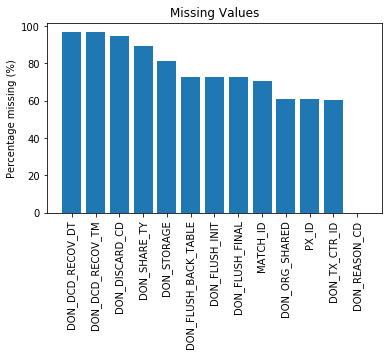

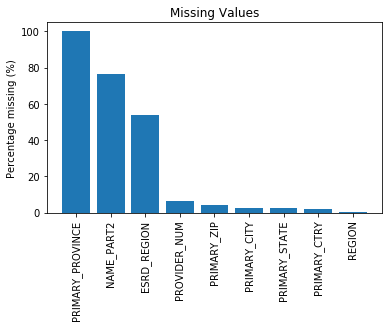

In [5]:
def plot_missing(df):
    '''Plot all features with missing values. Accepts
    dataframe as input. Displays bar graph showing
    percentage of missing values by feature.
    '''
    # Calculate missing value counts
    missing = df.isnull().sum()
    missing = pd.DataFrame(missing[missing > 0])

    # Rename and sort counts
    missing.columns = ['count']
    missing.sort_values(by='count', ascending = False, inplace = True)

    # Percentage missing
    missing['percent_missing'] = missing['count'] / len(df.index) * 100

    # Plot missing counts
    fig, ax = plt.subplots(figsize = (6,3.5))
    plt.bar(missing.index, missing['percent_missing'])
    plt.title('Missing Values')
    plt.ylabel('Percentage missing (%)')

    # Rotate x labels
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

plot_missing(donor_disposition)
plot_missing(institution)

Since there are 256 variables in the donor_deceased dataframe, we'll list the missing values instead

In [6]:
def list_missing(df):
    # Calculate missing value counts
    missing = df.isnull().sum()
    missing = pd.DataFrame(missing[missing > 0])

    # Rename and sort counts
    missing.columns = ['count']
    missing.sort_values(by='count', ascending = False, inplace = True)

    # Percentage missing
    missing['percent_missing'] = missing['count'] / len(df.index) * 100

    return(missing)

list_missing(donor_deceased)

,count,percent_missing
DON_COLD_ISCH_TM_ARRIV_KI,224469,99.973277
DON_INTRACRANIAL_CANCER_TYPE,224450,99.964815
DON_SKIN_CANCER_TYPE,224437,99.959025
DON_EXTRACRANIAL_CANCER_TYPE,224287,99.892219
DON_KI_GLOMER_SCLER_PCT,223612,99.591590
...,...,...
DON_AGE,45,0.020042
DON_AGE_IN_MONTHS,45,0.020042
DON_RECOV_OUT_US,33,0.014697
DON_RACE,18,0.008017


We note a lot of missing variables and it is a fair assumption that most of the data that is missing is due to an organ donor lacking the feature in question: for example, most donors may leave the cancer variable as blank since it is difficult to donate an organ if you have certain types of cancer. 

To impute these variables, we will first split the data into qualitative and quantitative variable types, and replace missing values with 'None' or '0' accordingly.

In [7]:
def return_variable_types(df):
    '''Divide dataset columns into qualitative and quantitative array.
    Accepts training data as an input.  Returns a list containing
    list elements of qualitative and quantitative feature names.
    '''
    # Group variables by type
    qualitative = [var for var in df.columns if np.dtype(df[var]) == 'object'].copy()
    quantitative = [var for var in df.columns if np.dtype(df[var]) != 'object'].copy()
    
    return qualitative, quantitative

def replace_missing(df):
    '''Replace missing values for qualitative and quantitative
    variables accordingly. Accepts dataframe as an input. 
    Outputs a new dataset with missing values replaced.
    '''

    # Group variables by type
    qualitative, quantitative = return_variable_types(df=df)

    # Identify missing values
    missing = df.columns[df.isnull().any()]

    # Replace with appropriate value according to type
    for col in missing:
        if col in qualitative:
            df[col] = df[col].fillna('None')
        elif col in quantitative:
            df[col] = df[col].fillna(0)      
    return df

##### The Dependent Variable - Donor Disposition

Donor Disposition codes are:

Code	Description

1.	Authorization Not Requested
2.	Authorization Not Obtained
3.	Organ Not Recovered
4. 	Recovered Not for Transplant
5.	Recovered for Transplant but Not Transplant
6.	Transplanted
7.	N/A

3.0    686199
6.0    657968
5.0    105109
1.0     99054
4.0     67787
2.0     56995
Name: DON_DISPOSITION, dtype: int64


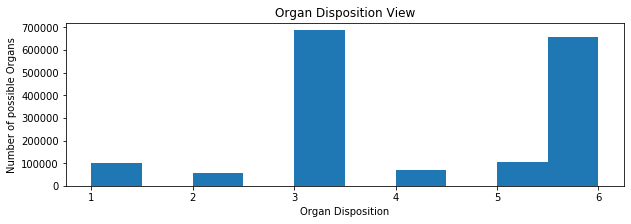

In [8]:
# Define figure
fig, axes = plt.subplots(1,1, figsize = (10,3))

# Histogram of sale price
axes.hist(donor_disposition['DON_DISPOSITION'])
axes.set_title('Organ Disposition View')
axes.set_xlabel('Organ Disposition')
axes.set_ylabel('Number of possible Organs')

print(donor_disposition['DON_DISPOSITION'].value_counts())

We want to examine only the donor disposition codes 5 and 6. Code 5 reveal those that were recovered for transplant, but not transplanted. Comparing against code 6, we can approach our main research question: What trends, if any, exist for the organs that are recovered to transplant, but discarded before being used?

## 2. Feature Engineering for all Models

For Institutions, we are primarily interest in identifying what OPOs are related to each center ID. We'll drop the other variables that are not of relevance keeping the aligned OPO, city, state, OPTN Member, and center id.

In [9]:
def institution_change():
    '''Takes the institution data set and drops variables and converts remaining
    variables from bytes to strings and returns a dataframe of each center ID with
    their aligning OPO, city, state, and if they are an OPTN member.
    '''
    
    new_institution = institution.copy()
    new_institution = new_institution.drop(new_institution.columns[[1,2,3,4,5,8,9,10,11,13]], axis=1)
    
    ## due to imported SAS dataset, convert strings from bytes to utf-8
    new_institution['CTR_CD'] = new_institution['CTR_CD'].str.decode("utf-8")
    new_institution['PRIMARY_CITY'] = new_institution['PRIMARY_CITY'].str.decode("utf-8")
    new_institution['PRIMARY_STATE'] = new_institution['PRIMARY_STATE'].str.decode("utf-8")
    
    new_institution.rename(columns= {'CTR_ID':'DON_OPO_CTR_ID'}, inplace=True)
    return new_institution.copy()

For the donor deceased file, we drop only the variables that have dates due to multicollinearity and a high amount of missing data.

In [10]:
def donor_deceased_change():
    '''Takes the donor_deceased data set and drops variables that have dates
    due to multicollinearity and a high amount of missing data. Returns the
    donor deceased dataset without the missing dates'''
    
    new_donor_deceased = donor_deceased.copy()
    new_donor_deceased = new_donor_deceased.drop(['DON_ALLOC_ECD_SERUM_CREAT_DT',
        'DON_REF_DT',
        'DON_DCD_SUPPORT_WITHDRAW_DT',
        'DON_DCD_AGONAL_BEGIN_DT',
        'DON_NON_HR_BEAT_CORE_COOL',
        'DON_DCD_ABDOM_AORTA_CANNUL_DT',
        'DON_DCD_THOR_AORTA_CANNUL_DT',
        'DON_DCD_PORTAL_VEIN_CANNUL_DT',
        'DON_DCD_PULM_ART_CANNUL_DT',
        'DON_CLAMP_DT',
        'DON_ALLOC_ECD_SERUM_CREAT_DT',
        'DON_TYP_METHCLASS1_DT',
        'DON_TYP_METHCLASS2_DT',
        'DON_RECOV_DT',
        'PERS_ID',
        'DON_TX'], axis = 1) 
    return new_donor_deceased.copy()

In [11]:
def create_full_dataset():
    '''Combine the different datasets into one full dataset to enable
    transformations to be applied more easily. Accepts inputs
    of train data and test data.  Outputs a full dataset with
    all features, minus the dependent variable (Donor Disposition).
    '''
    # Create full data by OPO
    
    ## Drops any data that is before the year 2000 due to the lack in accuracy
    ## for data before 2000. Also reduces the outlook to donor_disposition of 5 and 6 only
    don = donor_disposition.copy()
    don['DON_RECOV_DT'] = don['DON_RECOV_DT'].astype(str).str[:-6].astype(np.int64)
    don = don[(don['DON_DISPOSITION']==5) | (don['DON_DISPOSITION']==6)]
    don = don[don['DON_RECOV_DT'] > 1999]
    
    ## Dropping correlated variables to donor_disposition leaving only the following
    ## variables: donor ID, donor discard recovered date, donor disposition, donor organ
    ## and donor transplant center id
    don = don.drop(don.columns[[3,4,5,6,7,8,9,10,11,12,13,14,15,16]], axis=1)
    
    ## Imports new_institution and donor deceased to inner join with 
    ## the two on the center id and then inner join the result with the
    ## donor id on donor_disposition
    opo_map = institution_change() 
    donor_id = donor_deceased_change()

    ## Merge the donor dispositions.
    merge = pd.merge(donor_id, opo_map, on='DON_OPO_CTR_ID', how='inner')
    merged_data = pd.merge(don,merge, on='DONOR_ID', how='inner')
    
    ## Replace missing data with appropriate value according to type
    full_data = replace_missing(merged_data)  

    return full_data.copy()

 We use label encoding to encode the data. We considered using one hot encoding, but chose not to due to the side effect of one hot encoding: greatly increasing the feature space of our data set.

In [12]:
def label_encoder(full_data, columns):
    '''Label encode specified dataframe columns. Accepts
    inputs of pandas dataframe and columns to be encoded.
    Outputs a label encoded data frame.
    '''
    # Label encode all qualitative variables
    for col in columns:
        le = LabelEncoder()
        le.fit(list(full_data[col].values)) 
        full_data[col] = le.transform(list(full_data[col].values))
    return full_data

Now that we have defined our Label Encoder, its now time to transform our data. This will help to plot figures, express differences in data, etc.

In [13]:
def transform_data():
    
    full_transformed = create_full_dataset().copy()
      
    # Encode transformed dataset
    qualitative = [var for var in full_transformed.columns if np.dtype(full_transformed[var]) == 'object'].copy()
    
    full_transformed = label_encoder(full_transformed, qualitative)

    return full_transformed.copy()

Now that we have a function to combine the datasets and transform the variables, we also need a function to split the dataset into the components needed for machine learning models. The function will take the full dataset as defined by the create_full_dataset function above, and split it into training data, training labels, development data, development labels, and testing data.

This allows for all the models to be run on the same dataset, split using the same function.

In [14]:
def split_full_dataset(df):
    '''Splits the full dataset into required component parts
    for model training/testing.  Accepts inputs of full_data. 
    Outputs dataframes of train_data,
    train_labels, dev_data dev_labels, test_data.
    '''
    
    X = df.drop(['DON_DISPOSITION'], axis=1)
    
    replace = {5:0, 6:1}
    y = df['DON_DISPOSITION'].replace(replace)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
        
    return X_train, X_test, y_train, y_test

Creating the full dataset for model building

In [16]:
train_data, test_data, train_labels, test_labels = split_full_dataset(full_data)

## 3. Model Building

We are not trying to create a predictive model to be used, but rather to understand the dataset. We're going to start first with linear regression to give a basic understanding of the data. It should not yield great results and we have not validated the OLS assumptions to make it valid, but will show us a basic understanding of the residuals. From there, we'll explore logistic regression since it is a binary classification problem. Then we'll look specifically at information gain with a decision tree, random forest and gradient boosting to understand the key variables that are relevant in predicting if an organ will be discarded. From there, we can identify more relevant variables that we wish to explore further in understanding their relationship with organ disposition.

A. Linear Regression

Linear Regression
Features: 247
R^2: 0.2033


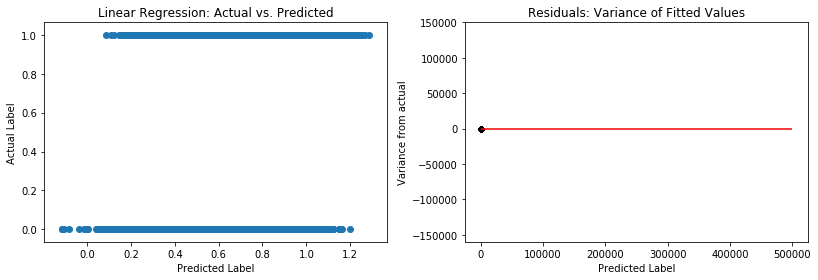

In [17]:
def linear_regression(plots=True, train_data=train_data, test_data=test_data, train_labels=train_labels, test_labels=test_labels):
    '''Fits a linear regression model and plots the results to include the residuals.'''
    lr = LinearRegression()
    lr.fit(train_data, train_labels)
    pred_data = lr.predict(test_data)
    
    # R^2
    print('Linear Regression')
    print('Features: {}'.format(train_data.shape[1]))
    print('R^2: {:.4f}'.format(lr.score(test_data, test_labels)))
    
    if plots == True:

        # Plot predicted vs. actual values
        fig, axes = plt.subplots(1,2,figsize = (11.5,4))

        # Calculate regression line
        slope, intercept, r_value, p_value, std_err = stats.linregress(test_labels, pred_data)
        line_x = np.arange(test_labels.min(), test_labels.max())
        line_y = slope*line_x + intercept

        # Plot data and regression line
        axes[0].scatter(pred_data, test_labels)
        axes[0].plot(line_x, line_y, color='red', linestyle = '--')

        axes[0].set_title('Linear Regression: Actual vs. Predicted')
        axes[0].set_xlabel('Predicted Label')
        axes[0].set_ylabel('Actual Label')

        # Plot residuals
        axes[1].scatter(pred_data, pred_data - test_labels, color='black', s=20)
        axes[1].hlines(y=0, xmin= 0, xmax=500000, colors='red')

        axes[1].set_title('Residuals: Variance of Fitted Values')
        axes[1].set_xlabel('Predicted Label')
        axes[1].set_ylabel('Variance from actual')
        axes[1].set_ylim(-160000,150000)

        fig.tight_layout()
    
linear_regression()

As we can see, because there are only two results, we choose to ignore linear regression and jump straight into binary classification models.

As we add more features to our model, it's complexity increases which in turn increases variance and reduces bias. This makes the model more prone to overfitting. The goal is to find the optimal point where the decrease in bias is equal to the increase in variance. To achieve this it is necessary to either reduce model complexity or introduce regularization. The next section will look at the modeling effects of Lasso Regression, which uses L1 regularization to select features with the greatest coefficients.

B. Logistic Regression


Logistic Regression with L1 regularization minimizes the Residual Sum of Squares (RSS) plus the sum of absolute value of the magnitude of the coefficient weights. The effect is that the magnitude of the coefficients shrinks as alpha is increased, thereby reducing the feature space. It is an effective ways to select those features that best describe the variance of the dependent variable, in this case if an organ is discarded or not. Our data also contains a number of highly correlated variables, and lasso regression accounts for this by arbitrarily select one of the features and setting the coefficient size to zero for all others.

Logistic Regression
C: 1
R^2: 0.8613
[tn, fp, fn, tp]
[   274  24836    276 155690]
              precision    recall  f1-score   support

         0.0       0.50      0.01      0.02     25110
         1.0       0.86      1.00      0.93    155966

    accuracy                           0.86    181076
   macro avg       0.68      0.50      0.47    181076
weighted avg       0.81      0.86      0.80    181076



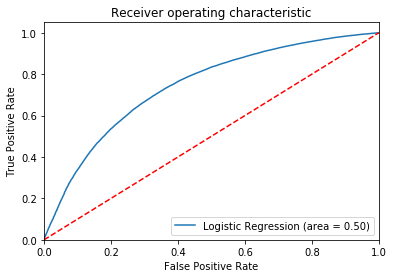

In [18]:
def logistic_regression(C, plots=False, train_data=train_data, test_data=test_data, train_labels=train_labels, test_labels=test_labels):
    '''Fit logistic regression model, make predictions and
    display results. Accepts input of full_data and
    returns (prints) model accuracy.
    '''

    # Logistic Regression - fit the model and predict
    logistic = LogisticRegression(C=C, solver='liblinear')
    logistic.fit(train_data, train_labels)
    predict_labels = logistic.predict(test_data)

    print('Logistic Regression')
    print('C:', C)
    print('R^2: {:.4f}'.format(logistic.score(test_data,test_labels)))
    
    # Shows confusion matrix and the classification report for hyperparameter tuning.
    print("[tn, fp, fn, tp]")
    print(confusion_matrix(test_labels, predict_labels).ravel())
    print(classification_report(test_labels, predict_labels))
    
    # Plot to show ROC curve
    logit_roc_auc = roc_auc_score(test_labels, logistic.predict(test_data))
    fpr, tpr, thresholds = roc_curve(test_labels, logistic.predict_proba(test_data)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()
          
logistic_regression(C=1)

Although fitting a logistic regression model is interesting, it doesn't truly help us understand the variables. Next we look at decision trees as they can allow us to see which variables give us the most information gain.

D. Decision Trees

In [19]:
def decision_tree(train_data=train_data, test_data=test_data, train_labels=train_labels, test_labels=test_labels):
    
    # Fit the Decision Tree Classification model with default parameters
    decision_tree = DecisionTreeClassifier(min_samples_split=100)
    decision_tree.fit(train_data, train_labels)
    
    # Make prediction
    predict_labels = decision_tree.predict(test_data)
    
    print('Decision Tree Classifier')
    print('Accuracy: {:.4f}'.format(decision_tree.score(test_data, test_labels)))
    
    # Top features for information gain
    importances = decision_tree.feature_importances_
    indices = np.argsort(importances)[::-1]
    print("\nTop features for information gain in decision tree splits")
    for f in range(10):
        print("{0}. {1}  ({2:5f})".format((f+1), train_data.columns[indices[f]], importances[indices[f]]))

decision_tree()

Decision Tree Classifier
Accuracy: 0.8756

Top features for information gain in decision tree splits
1. DON_ORG  (0.173497)
2. DON_LF_KI_GLOMER_SCLER_PCT  (0.154326)
3. DON_EXPAND_DON_KI  (0.062125)
4. DON_AGE_IN_MONTHS  (0.045566)
5. DON_LF_KI_TXFER_PUMP  (0.032700)
6. DON_RT_KI_TXFER_PUMP  (0.023312)
7. DON_HCV_STAT  (0.023174)
8. DON_CREAT  (0.022538)
9. DON_LI_BIOPSY_MACRO_FAT  (0.020567)
10. DON_WGT_KG  (0.020557)


The results show that come key variables give a lot of information gain when predicting organ discards. A decision tree is considered a weak learner and therefore may not be completely accurate because we may be overfitting due to the variance-bias tradeoff. 

A solution to that is to consider a random forest model that takes a collection of decision trees and takes the average of the results. 

E. Random Forest

In [20]:
def random_forest(train_data=train_data, test_data=test_data, train_labels=train_labels, test_labels=test_labels):
    
    # Fit the Decision Tree Classification model with default parameters
    random_forest = RandomForestClassifier(min_samples_split=100)
    random_forest.fit(train_data, train_labels)
    
    # Make prediction
    predict_labels = random_forest.predict(test_data)
    
    print('Random Forest Classifier')
    print('Accuracy: {:.4f}'.format(random_forest.score(test_data, test_labels)))
    
    # Top features for information gain
    importances = random_forest.feature_importances_
    indices = np.argsort(importances)[::-1]
    print("\nTop features for information gain in decision tree splits")
    for f in range(10):
        print("{0}. {1}  ({2:5f})".format((f+1), train_data.columns[indices[f]], importances[indices[f]]))

random_forest()

C:\Users\Theod\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest Classifier
Accuracy: 0.8898

Top features for information gain in decision tree splits
1. DON_ORG  (0.091370)
2. DON_LF_KI_GLOMER_SCLER_PCT  (0.061391)
3. DON_AGE_IN_MONTHS  (0.057090)
4. DON_RT_KI_GLOMER_SCLER_PCT  (0.041094)
5. DON_EXPAND_DON_FLG_OPTN  (0.038231)
6. DON_AGE  (0.038054)
7. DON_BIOPSY_DGN  (0.023796)
8. DON_RT_KI_TXFER_PUMP  (0.022721)
9. DON_EXPAND_DON_KI  (0.022188)
10. DON_RT_KI_BIOPSY  (0.020243)


As expected, the random forest model revealed different results than the decision tree, although some variables importance stayed the same.

However, although we're close to a decent result, we have to consider one last aspect: Unbalanced Classes. Since we have a class imbalance (meaning that the number of discards versus transplants are not equal), gradient boosting is another method to counter the problem of unbalanced classes. Gradient boosting works similar to random forests, but subtle changes such as instead of each decision tree being built independently, gradient boosting builds one tree at a time and adds upon the previous tree one at a time.

F. Gradient Boosted Decision Tree

In [21]:
def gradient_boosted_decision_tree(train_data=train_data, test_data=test_data, train_labels=train_labels, test_labels=test_labels):
    '''Takes the same data that we used for previous models but runs it in
    a gradient boosting classifer.
    '''
    # Fit the Decision Tree Classification model with default parameters
    gb_dt = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01)
    gb_dt.fit(train_data, train_labels)
    
    # Make prediction
    predict_labels = gb_dt.predict(test_data)
    
    print('Gradient Boosted Decision Tree Classifier')
    print('Accuracy: {:.4f}'.format(gb_dt.score(test_data, test_labels)))
    
    # Top features for information gain
    importances = gb_dt.feature_importances_
    indices = np.argsort(importances)[::-1]
    print("\nTop features for information gain in decision tree splits")
    for f in range(10):
        print("{0}. {1}  ({2:5f})".format((f+1), train_data.columns[indices[f]], importances[indices[f]]))

gradient_boosted_decision_tree()

Gradient Boosted Decision Tree Classifier
Accuracy: 0.8725

Top features for information gain in decision tree splits
1. DON_ORG  (0.246997)
2. DON_LF_KI_GLOMER_SCLER_PCT  (0.215877)
3. DON_RT_KI_GLOMER_SCLER_PCT  (0.204259)
4. DON_EXPAND_DON_KI  (0.117251)
5. DON_LF_KI_TXFER_PUMP  (0.052615)
6. DON_EJECT_FRACT_METH  (0.032567)
7. DON_RT_KI_TXFER_PUMP  (0.032101)
8. DON_HCV_STAT  (0.029045)
9. DON_AGE_IN_MONTHS  (0.026292)
10. DON_LF_KI_BIOPSY  (0.018175)


## 4. Kidney Disposition

Since we noticed that the specified organ gives a high information gain, we then decided to re-analyze the data with just Kidneys.

In [22]:
# Creates the same dataset with all organs
ki_dataset = create_full_dataset()

In [23]:
# Removes all organs in the dataset that is not a kidney. The b'str' is because
# the data originally came from SAS datasets and thus was inputted as a byte string.
kidneys = ki_dataset[(ki_dataset.DON_ORG ==b'LKI') | (ki_dataset.DON_ORG ==b'RKI') | (ki_dataset.DON_ORG ==b'EKI')]

In [24]:
def ki_transform_data(kidneys=kidneys):
    '''Transforms the qualitative variables within the dataset and turns it into numerical numbers
    for analytics purposes. Returns the transformed dataset.
    '''
    full_transformed = kidneys.copy()
    
    # Encode transformed dataset
    qualitative = [var for var in full_transformed.columns if np.dtype(full_transformed[var]) == 'object'].copy()
    
    full_transformed = label_encoder(full_transformed, qualitative)

    return full_transformed.copy()

ki_transformed = ki_transform_data()

Now that we've transformed the kidney dataset we will re-run the analysis we did in section 3. We will split the data set, run logistic regression, identify key variables in information gain, and then explore a smaller dataframe with logistic regression.

In [25]:
ki_train_data, ki_test_data, ki_train_labels, ki_test_labels = split_full_dataset(ki_transformed)

Logistic Regression
C: 1
R^2: 0.8428
[tn, fp, fn, tp]
[ 4191 12758  2182 75900]
              precision    recall  f1-score   support

         0.0       0.66      0.25      0.36     16949
         1.0       0.86      0.97      0.91     78082

    accuracy                           0.84     95031
   macro avg       0.76      0.61      0.63     95031
weighted avg       0.82      0.84      0.81     95031



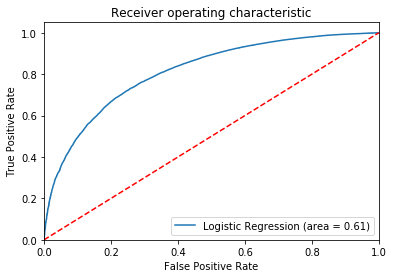

In [26]:
logistic_regression(C=1, plots=False, train_data=ki_train_data, test_data=ki_test_data, train_labels=ki_train_labels, test_labels=ki_test_labels)

In [27]:
decision_tree(train_data=ki_train_data, test_data=ki_test_data, train_labels=ki_train_labels, test_labels=ki_test_labels)

Decision Tree Classifier
Accuracy: 0.8714

Top features for information gain in decision tree splits
1. DON_LF_KI_GLOMER_SCLER_PCT  (0.270367)
2. DON_EXPAND_DON_KI  (0.100926)
3. DON_AGE_IN_MONTHS  (0.047713)
4. DON_LF_KI_TXFER_PUMP  (0.042447)
5. DON_RT_KI_TXFER_PUMP  (0.041417)
6. DON_RT_KI_GLOMER_SCLER_PCT  (0.039225)
7. DON_HCV_STAT  (0.037666)
8. DON_MAX_CREAT  (0.025695)
9. DON_CREAT  (0.022799)
10. DON_ORG  (0.015491)


In [28]:
random_forest(train_data=ki_train_data, test_data=ki_test_data, train_labels=ki_train_labels, test_labels=ki_test_labels)

C:\Users\Theod\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest Classifier
Accuracy: 0.8855

Top features for information gain in decision tree splits
1. DON_EXPAND_DON_KI  (0.114551)
2. DON_LF_KI_GLOMER_SCLER_PCT  (0.088636)
3. DON_AGE_IN_MONTHS  (0.059276)
4. DON_RT_KI_GLOMER_SCLER_PCT  (0.055278)
5. DON_EXPAND_DON_FLG_OPTN  (0.039526)
6. DON_AGE  (0.036004)
7. DON_RT_KI_TXFER_PUMP  (0.033381)
8. DON_CREAT  (0.032486)
9. DON_ALLOC_ECD_HYPERTEN  (0.026686)
10. DON_RT_KI_BIOPSY  (0.026039)


In [29]:
gradient_boosted_decision_tree(train_data=ki_train_data, test_data=ki_test_data, train_labels=ki_train_labels, test_labels=ki_test_labels)

Gradient Boosted Decision Tree Classifier
Accuracy: 0.8526

Top features for information gain in decision tree splits
1. DON_LF_KI_GLOMER_SCLER_PCT  (0.327902)
2. DON_RT_KI_GLOMER_SCLER_PCT  (0.267994)
3. DON_EXPAND_DON_KI  (0.122771)
4. DON_LF_KI_TXFER_PUMP  (0.065585)
5. DON_RT_KI_TXFER_PUMP  (0.054876)
6. DON_AGE_IN_MONTHS  (0.050441)
7. DON_HCV_STAT  (0.043441)
8. DON_CREAT  (0.025546)
9. DON_MAX_CREAT  (0.021975)
10. DON_AGE  (0.006349)


You may have seen a common trend. Yes, the same variables continue to be involved in identifying kidney disposition. In fact, it is interesting that 7 of the same variables were relevant when looking at both all organs and kidneys. Now we will create a smaller dataset but just isolate the key variables for information gain and see if we can find more understanding in the relationship.

In [30]:
# First create the original dataset
small_dataset = create_full_dataset()

In [31]:
# Removes all organs in the dataset that is not a kidney. The b'str' is because
# the data originally came from SAS datasets and thus was inputted as a byte string.
small = small_dataset[(small_dataset.DON_ORG ==b'LKI') | (small_dataset.DON_ORG ==b'RKI') | (small_dataset.DON_ORG ==b'EKI')]

In [32]:
small = small[['DON_ORG',
               'CTR_CD',
               'DON_RECOV_DT',
               'DON_LF_KI_GLOMER_SCLER_PCT',
               'DON_RT_KI_GLOMER_SCLER_PCT',
               'DON_EXPAND_DON_KI',
               'DON_LF_KI_TXFER_PUMP',
               'DON_RT_KI_TXFER_PUMP',
               'DON_HCV_STAT',
               'DON_AGE',
               'DON_CREAT',
               'DON_DISPOSITION']].copy()

small.shape

(287971, 12)

Now that we've created the dataset with the top variables from our earlier analysis, and added in the OPO, and year, we will now examine their relationships.

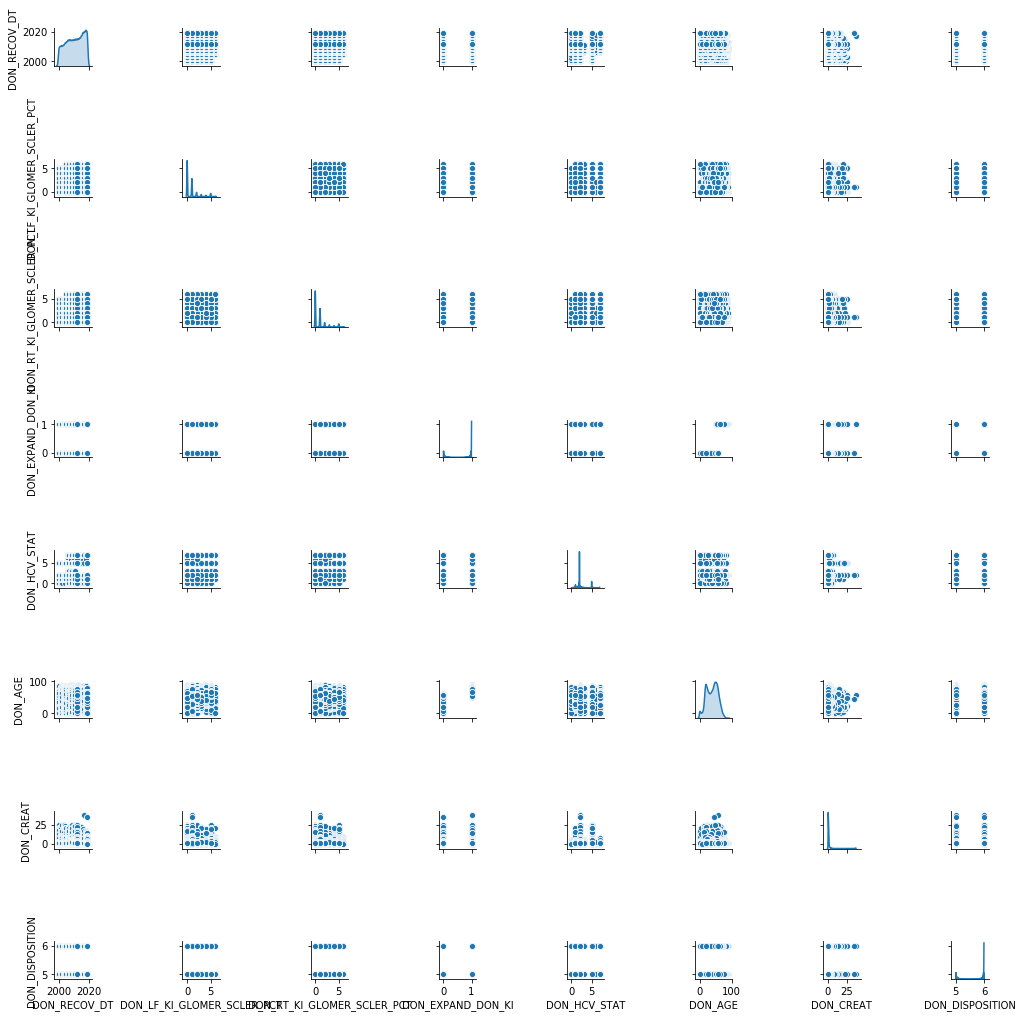

In [51]:
def pairplots(df):
    '''Plot the distributions of all quantitative variables
    contained in the raw training data.
    '''
    # Replace missing for train
    #new_df = replace_missing(df)
    
    # Generate plot for key features
    cols = df.columns
    sns.pairplot(df[cols], diag_kind='kde', height = 1.75)
    plt.show()
    
pairplots(small)

The big takewaway from the correlation matrix above is to examine the variable distribution. In this case, the big takeaways are that Donor Disposition is an unbalanced class.

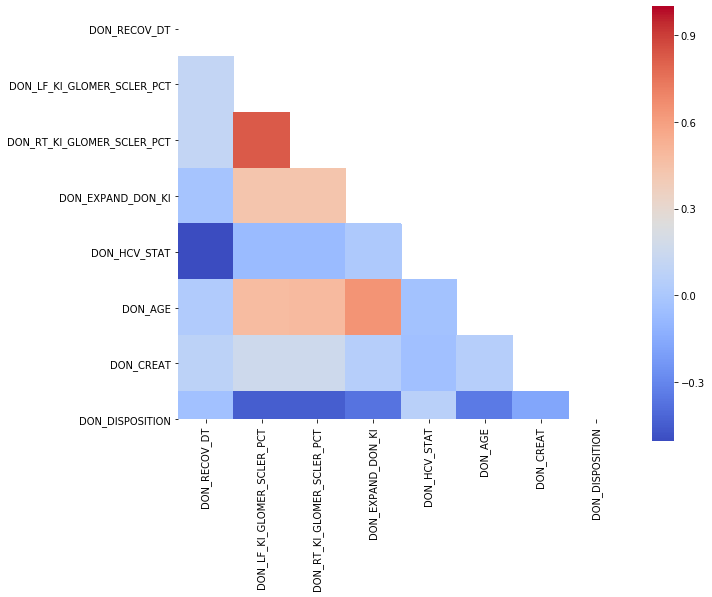

In [34]:
def correlation_matrix(df):
    '''Plot correlation matrix for dataset. Accepts
    dataframe as input. Displays upper triangular
    heat map of correlations.
    '''  
    
    # Create correlation matrix
    corr = df.corr()

    # Define figure size
    plt.rcParams['figure.figsize'] = (10, 10)

    # Mask upper triangle
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    # Plot heapmat
    sns.heatmap(corr, mask=mask, square=True, cmap='coolwarm', cbar_kws={"shrink": 0.8})
    
correlation_matrix(small)

In [35]:
small[small['DON_DISPOSITION']==5].describe()

,DON_RECOV_DT,DON_LF_KI_GLOMER_SCLER_PCT,DON_RT_KI_GLOMER_SCLER_PCT,DON_EXPAND_DON_KI,DON_HCV_STAT,DON_AGE,DON_CREAT,DON_DISPOSITION
count,51425.000000,51425.000000,51425.000000,51425.000000,51425.000000,51425.000000,51425.000000,51425.0
mean,2011.013087,2.149091,2.132037,0.528362,2.254215,52.084395,1.630695,5.0
std,5.592080,1.882134,1.859577,0.499200,1.100924,15.733862,1.384795,0.0
min,2000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.0
25%,2007.000000,1.000000,1.000000,0.000000,2.000000,45.000000,0.900000,5.0
50%,2012.000000,1.000000,1.000000,1.000000,2.000000,55.000000,1.200000,5.0
75%,2016.000000,4.000000,4.000000,1.000000,2.000000,63.000000,1.900000,5.0
max,2019.000000,6.000000,6.000000,1.000000,7.000000,88.000000,37.000000,5.0


In [36]:
small[small['DON_DISPOSITION']==6].describe()

,DON_RECOV_DT,DON_LF_KI_GLOMER_SCLER_PCT,DON_RT_KI_GLOMER_SCLER_PCT,DON_EXPAND_DON_KI,DON_HCV_STAT,DON_AGE,DON_CREAT,DON_DISPOSITION
count,236546.000000,236546.000000,236546.000000,236546.000000,236546.000000,236546.000000,236546.000000,236546.0
mean,2010.406919,0.583295,0.592062,0.140036,2.442831,36.660662,1.137434,6.0
std,5.766612,0.991531,0.991570,0.347025,1.156307,16.224167,0.977910,0.0
min,2000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.0
25%,2006.000000,0.000000,0.000000,0.000000,2.000000,23.000000,0.700000,6.0
50%,2011.000000,0.000000,0.000000,0.000000,2.000000,37.000000,0.900000,6.0
75%,2016.000000,1.000000,1.000000,0.000000,2.000000,50.000000,1.300000,6.0
max,2019.000000,6.000000,6.000000,1.000000,7.000000,88.000000,37.000000,6.0


When we focus primarily on donor disposition, we note that a higher kidney discard rate is associated with :
 - Older Donor Age
 - Higher Kidney Glomerular Sclerosis on Kidney Biopsy
 - If a Donor meets expanded donor criteria for kidneys
 - Positive HCV Antibody Status 
 - Higher Donor Creatine

In [60]:
small_transformed = ki_transform_data(kidneys=small)

In [61]:
small_train_data, small_test_data, small_train_labels, small_test_labels = split_full_dataset(small_transformed)

Logistic Regression
C: 1
R^2: 0.8622
[tn, fp, fn, tp]
[ 7038  9911  3188 74894]
              precision    recall  f1-score   support

         0.0       0.69      0.42      0.52     16949
         1.0       0.88      0.96      0.92     78082

    accuracy                           0.86     95031
   macro avg       0.79      0.69      0.72     95031
weighted avg       0.85      0.86      0.85     95031



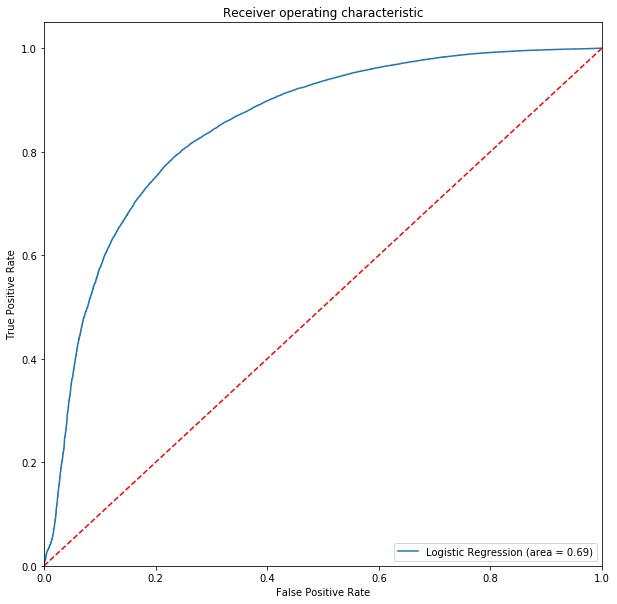

In [62]:
logistic_regression(C=1, plots=False, train_data=small_train_data, test_data=small_test_data, train_labels=small_train_labels, test_labels=small_test_labels)

Comparing our initial results from logistic regression, we reduce the amount of false negatives/positives in half, indicating that our model is much more accurate with the current variables.

Our results from the smaller dataset verifies that our key variables have a strong relation to kidney disposition.

## 5. Conclusion

We explored the donor disposition dataset and conducted a very basic EDA, transformed the variables into a way we can examine the dataset in more depth and then used the results to re-examine their relationship with kidney disposition.

We discovered that some variables have an impact if a kidney will be recovered for transplants, but will be discarded before being transplanted, but we could not find a statistically relevant relationship between organ discards and location.

The variables that predict a kidney organ discard are:
 - Older Donor Age
 - Higher Kidney Glomerular Sclerosis on Kidney Biopsy
 - If a Donor meets expanded donor criteria for kidneys
 - Positive HCV Antibody Status 
 - Higher Donor Creatine
 
Next steps to take this project further could include analyzing the other organs and relevant variables for each organ. Another approach could examine trends within each OPO. Finally, we examined our data from 2000-2019. Perhaps a better model would be one trained on 5-years of historic data and continuously refined in the subsequential 5-year increments as we have over 30+ years of data.

# Appendix
## Understanding Organ Disposition by OPO, Year, and organ

For creating the Tableau visualizaiton of the OPO disposition by year and by organ, we made the following steps.

In [44]:
# First, create the full dataset for all organs.
all_organs = create_full_dataset()

In [45]:
# Next, group the dataframe by OPO, Donor Recovery Date, and by Donor organ
all_organs_grouped = all_organs.groupby(['DON_OPO_CTR_ID', 'DON_RECOV_DT', 'DON_ORG'])

In [46]:
# Then evaluate the grouped dataframe by the Donor disposition variable. Here we will look
# at both value counts and the normalized percentage value of the value counts. The results
# will be in an excel file that shows the results for our visualization.
with pd.ExcelWriter('all_organs_grouped.xlsx') as writer:
    all_organs_grouped['DON_DISPOSITION'].value_counts().to_excel(writer, sheet_name='value_counts')
    (all_organs_grouped['DON_DISPOSITION'].value_counts(normalize=True)*100).to_excel(writer, sheet_name='normalized_value')

In [47]:
# Next we'll want to examine just kidneys. We'll just separate kidneys from the dataset
# and conduct the same analysis.

all_organs_2 = all_organs.copy()
li_only = all_organs_2[(all_organs_2.DON_ORG ==b'LKI') | (all_organs_2.DON_ORG ==b'RKI') | (all_organs_2.DON_ORG ==b'EKI')]

In [48]:
# Next, group the dataframe by OPO, Donor Recovery Date, and by Donor organ
li_only_grouped = li_only.groupby(['DON_OPO_CTR_ID', 'DON_RECOV_DT', 'DON_ORG'])

In [49]:
# Then evaluate the grouped dataframe by the Donor disposition variable. Here we will look
# at both value counts and the normalized percentage value of the value counts. The results
# will be in an excel file that shows the results for our visualization.
with pd.ExcelWriter('li_only_grouped.xlsx') as writer:
    li_only_grouped['DON_DISPOSITION'].value_counts().to_excel(writer, sheet_name='value_counts')
    (li_only_grouped['DON_DISPOSITION'].value_counts(normalize=True)*100).to_excel(writer, sheet_name='normalized_value')